🚀 Step 1: Connecting to WRDS and setting parameters...
Make sure your 'wrds_credentials.txt' file is in the correct location.
Loading library list...
Loading library list...
Done
User tr2829 connected.
✅ Parameters set. Target: 25 diversified stocks.

🚀 Step 2: Selecting the universe of 25 diversified stocks...
Using end date: 2024-12-31
✅ Universe of 25 stocks identified.
Stocks found: ['AAPL', 'AMT', 'AMZN', 'APD', 'BAC', 'CAT', 'COST', 'CSCO', 'CVX', 'GOOGL', 'HD', 'HON', 'JNJ', 'JPM', 'KO', 'META', 'MSFT', 'NEE', 'PFE', 'PG', 'SHW', 'SO', 'UNH', 'WFC', 'XOM']

🚀 Step 3: Downloading historical data...
Done
User tr2829 connected.
✅ Parameters set. Target: 25 diversified stocks.

🚀 Step 2: Selecting the universe of 25 diversified stocks...
Using end date: 2024-12-31
✅ Universe of 25 stocks identified.
Stocks found: ['AAPL', 'AMT', 'AMZN', 'APD', 'BAC', 'CAT', 'COST', 'CSCO', 'CVX', 'GOOGL', 'HD', 'HON', 'JNJ', 'JPM', 'KO', 'META', 'MSFT', 'NEE', 'PFE', 'PG', 'SHW', 'SO', 'UNH', 'WFC',

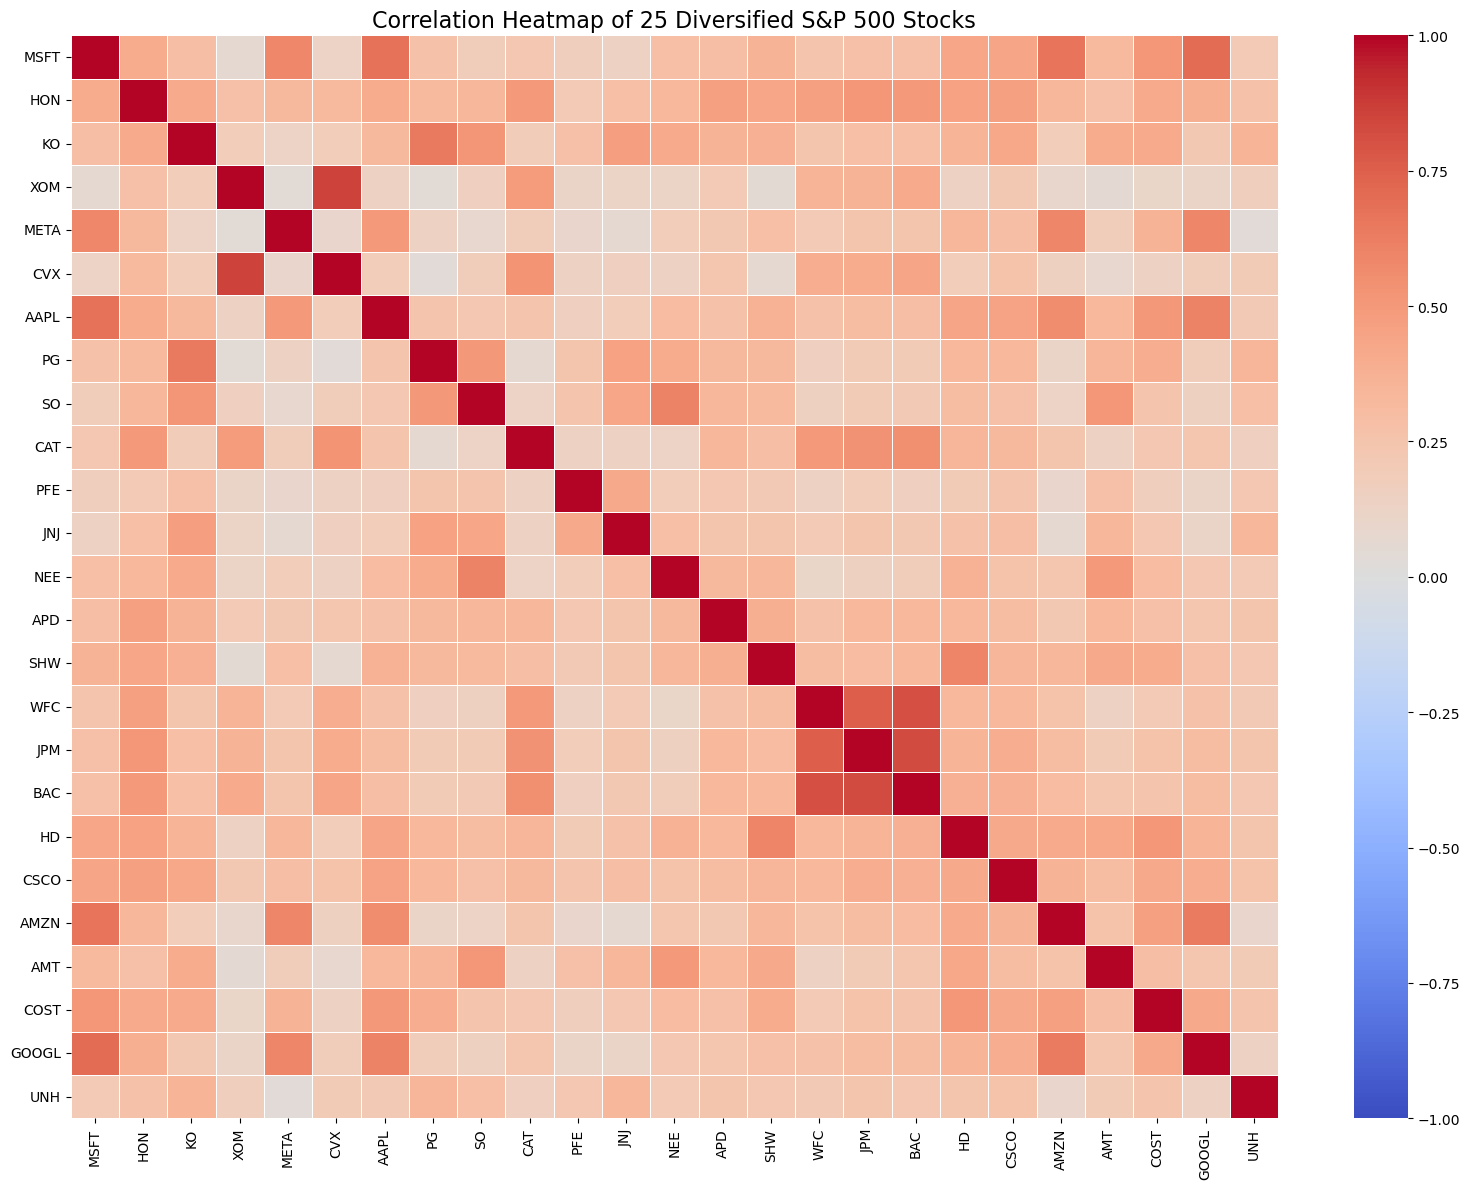


📊 Analysis 2: Calculating average correlation...
✅ Portfolio average correlation (off-diagonal): 0.2958
-> Interpretation: Average correlation is moderate. Diversification is present but limited.

📊 Analysis 4: Principal Component Analysis (PCA)...
✅ The first principal component (PC1) alone explains 33.15% of total variance.
-> Interpretation: PC1 represents 'the market'. If this number is high (e.g., > 50%),
   it means a single factor (general market movement) drives most
   of your portfolio's behavior. This indicates LOW diversification.
✅ 11 components are required to explain 80% of the variance.
-> Interpretation: If this number is low (e.g., 1, 2 or 3), the portfolio is poorly diversified.
   If it is high (e.g., 10 or more), the portfolio is well diversified.
-> Displaying PCA Scree Plot.


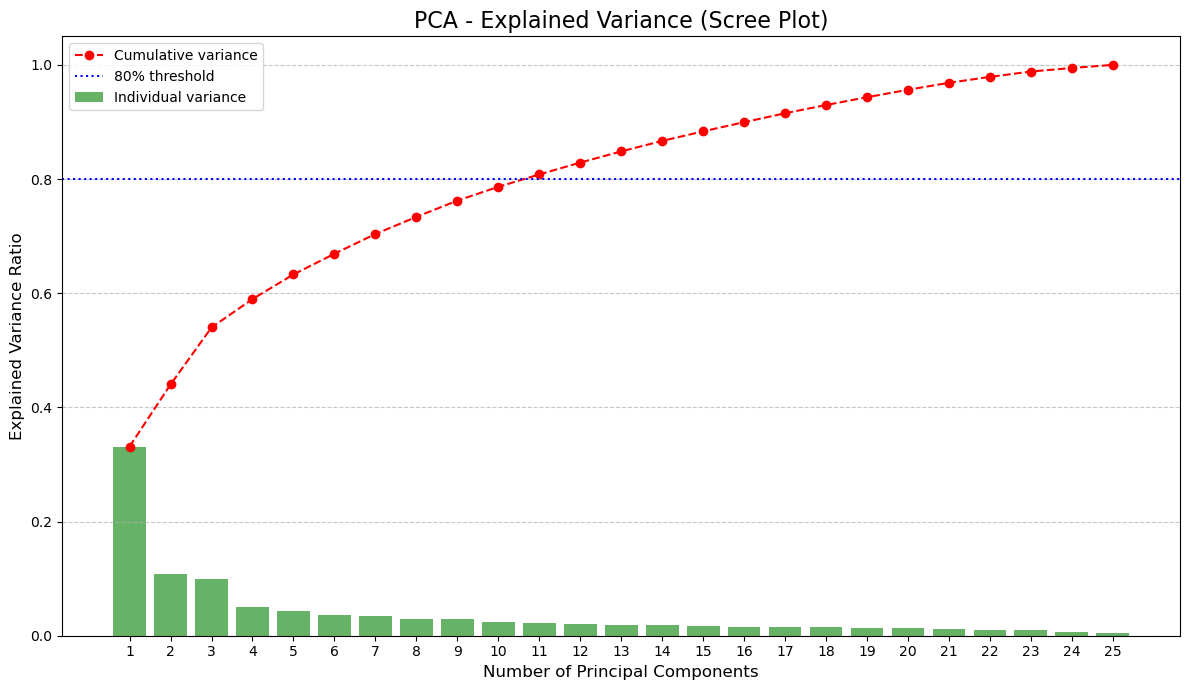


🎉 Diversification analysis completed.


In [1]:
import pandas as pd
import numpy as np
import wrds
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns  # Added for heatmap
from sklearn.decomposition import PCA  # Added for Principal Component Analysis
from sklearn.preprocessing import StandardScaler # Added for PCA


# =============================================================================
# STEP 1: WRDS CONNECTION AND PARAMETERS
# =============================================================================
print("🚀 Step 1: Connecting to WRDS and setting parameters...")
print("Make sure your 'wrds_credentials.txt' file is in the correct location.")
try:
    with open("wrds_credentials.txt", "r") as f:
        lines = f.read().splitlines()
        user = lines[0]
        pwd = lines[1]
    db = wrds.Connection(wrds_username=user, wrds_password=pwd)
    print(f"User {user} connected.")
except Exception as e:
    print(f"WRDS connection error. Check 'wrds_credentials.txt'. Error: {e}")
    exit()

end_date = '2025-01-30'
trading_days = 1000 # last 1000 days
start_date_approx = (pd.to_datetime(end_date) - pd.to_timedelta(trading_days * 1.8, unit='d')).strftime('%Y-%m-%d')

# List of 25 diversified tickers (selected by AI)
# ***** CHANGE HERE IF NEEDED *****
# 'LIN' was replaced by 'APD' (Air Products and Chemicals)
target_tickers = [
    'MSFT', 'AAPL', 'CSCO',  # Tech
    'JNJ', 'PFE', 'UNH',     # Health Care
    'JPM', 'BAC', 'WFC',     # Financials
    'GOOGL', 'META',         # Communication Services
    'AMZN', 'HD',            # Consumer Discretionary
    'PG', 'COST', 'KO',      # Consumer Staples
    'CAT', 'HON',            # Industrials
    'XOM', 'CVX',            # Energy
    'NEE', 'SO',             # Utilities
    'AMT',                   # Real Estate
    'APD', 'SHW'             # Materials (replacement of 'LIN' by 'APD')
]
target_tickers_tuple = tuple(target_tickers)
# num_stocks will be defined in Step 2 based on what is actually found
print(f"✅ Parameters set. Target: {len(target_tickers)} diversified stocks.")

# =============================================================================
# STEP 2: SELECT UNIVERSE (25 DIVERSIFIED STOCKS)
# =============================================================================
print(f"\n🚀 Step 2: Selecting the universe of {len(target_tickers)} diversified stocks...")
try:
    # 1. Get the last valid trading date
    query_last_date = f"SELECT max(date) as last_date FROM crsp.dsf WHERE date <= '{end_date}'"
    last_date_df = db.raw_sql(query_last_date, date_cols=['last_date'])
    
    if last_date_df['last_date'].iloc[0] is pd.NaT:
        print(f"No data found before or on {end_date}. Using today's date.")
        end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
        query_last_date = f"SELECT max(date) as last_date FROM crsp.dsf WHERE date <= '{end_date}'"
        last_date_df = db.raw_sql(query_last_date, date_cols=['last_date'])
        
    last_trading_day_str = last_date_df['last_date'][0].strftime('%Y-%m-%d')
    end_date = last_trading_day_str
    print(f"Using end date: {end_date}")

    # 2. Query to find PERMNOs for tickers, verifying S&P 500 membership
    query_universe = f"""
        WITH ticker_permnos AS (
            SELECT permno, ticker
            FROM crsp.msenames
            WHERE ticker IN {target_tickers_tuple}
            AND '{end_date}' BETWEEN namedt AND nameendt
        ),
        sp500_check AS (
            SELECT permno
            FROM crsp.msp500list
            WHERE start <= '2017-01-01' -- Seniority constraint
            AND ending >= '{end_date}'   -- Still in the index
            GROUP BY permno
        )
        SELECT a.permno, a.ticker
        FROM ticker_permnos AS a
        JOIN sp500_check AS b ON a.permno = b.permno
    """
    universe_df = db.raw_sql(query_universe)
    
    found_tickers = universe_df['ticker'].tolist()
    missing_tickers = list(set(target_tickers) - set(found_tickers))
    
    if missing_tickers:
        print(f"⚠️ Warning: The following tickers were not found or do not meet S&P 2017 criteria: {missing_tickers}")

    target_permno = universe_df['permno'].tolist()
    permno_tuple = tuple(target_permno)
    
    # ***** ROBUSTNESS CHANGE *****
    # Make the code robust: num_stocks is the number of stocks actually found
    num_stocks = len(target_permno) 
    
    # Create PERMNO -> Ticker mapping for future use
    permno_to_ticker_map = universe_df.set_index('permno')['ticker'].to_dict()
    
    print(f"✅ Universe of {num_stocks} stocks identified.")
    print(f"Stocks found: {found_tickers}")

except Exception as e:
    print(f"Error while selecting the universe: {e}")
    db.close()
    exit()
    
if not permno_tuple:
    print("No stocks match the criteria. Exiting script.")
    db.close()
    exit()

# =============================================================================
# STEP 3: DOWNLOAD HISTORICAL DATA
# =============================================================================
print("\n🚀 Step 3: Downloading historical data...")
# Simplified query since we already have tickers
query_data = f"""
    SELECT a.permno, a.date, a.ret, b.dlret
    FROM crsp.dsf AS a
    LEFT JOIN crsp.dsedelist AS b ON a.permno = b.permno AND a.date = b.dlstdt
    WHERE a.permno IN {permno_tuple} AND a.date BETWEEN '{start_date_approx}' AND '{end_date}'
"""
daily_data = db.raw_sql(query_data, date_cols=['date'])

all_dates = sorted(daily_data['date'].unique())
final_dates = all_dates[-trading_days:]
daily_data = daily_data[daily_data['date'].isin(final_dates)]
print("✅ Download complete.")
db.close()
print("🔒 WRDS connection closed.")

# =============================================================================
# STEP 4: CLEANING AND MATRIX CONSTRUCTION
# =============================================================================
print("\n🚀 Step 4: Cleaning and building the final matrix...")
daily_data['ret'] = pd.to_numeric(daily_data['ret'], errors='coerce').fillna(0)
daily_data['dlret'] = pd.to_numeric(daily_data['dlret'], errors='coerce').fillna(0)
daily_data['effective_ret'] = (1 + daily_data['ret']) * (1 + daily_data['dlret']) - 1
daily_data['price_relative'] = 1 + daily_data['effective_ret']
final_matrix_relatives = daily_data.pivot(index='date', columns='permno', values='price_relative')

# More robust handling of NaNs
final_matrix_relatives.ffill(inplace=True) # First forward fill
final_matrix_relatives.fillna(1.0, inplace=True) # Fill remaining NaNs (start of series)

print("✅ Price relatives matrix constructed!")
print("\n--- Stocks in the backtest universe ---")
tickers_in_matrix = [permno_to_ticker_map.get(p, str(p)) for p in final_matrix_relatives.columns]
print(tickers_in_matrix)
print(f"Matrix shape: {final_matrix_relatives.shape}")
print("------------------------------------------\n")

# =============================================================================
# STEP 5: DIVERSIFICATION ANALYSIS
# =============================================================================
print("🚀 Step 5: Diversification analysis...")

# 1. Prepare returns matrix (not relatives)
returns_matrix = final_matrix_relatives - 1

# 2. Rename columns with Tickers for readable charts
returns_matrix.columns = [permno_to_ticker_map.get(col, str(col)) for col in returns_matrix.columns]

# --- Method 1: Correlation Heatmap ---
print("\n📊 Analysis 1: Generating correlation heatmap...")
corr_matrix = returns_matrix.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(
    corr_matrix, 
    annot=False,  # 'annot=True' would be unreadable with 25x25
    cmap='coolwarm', # Use 'coolwarm' (blue-red) to emphasize extremes
    vmin=-1, 
    vmax=1,
    linewidths=.5,
    xticklabels=corr_matrix.columns,
    yticklabels=corr_matrix.columns
)
plt.title(f'Correlation Heatmap of {num_stocks} Diversified S&P 500 Stocks', fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
print("-> Displaying heatmap.")
plt.show()

# --- Method 2: Average Correlation ---
print("\n📊 Analysis 2: Calculating average correlation...")
upper_triangle = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)]
mean_corr = upper_triangle.mean()

print(f"✅ Portfolio average correlation (off-diagonal): {mean_corr:.4f}")
if mean_corr > 0.5:
    print("-> Interpretation: Average correlation is high. The portfolio is NOT well diversified.")
elif mean_corr > 0.2:
    print("-> Interpretation: Average correlation is moderate. Diversification is present but limited.")
else:
    print("-> Interpretation: Average correlation is low. The portfolio is WELL diversified.")

# --- Method 4: Principal Component Analysis (PCA) ---
print("\n📊 Analysis 4: Principal Component Analysis (PCA)...")

# 1. Standardize data (very important for PCA)
scaler = StandardScaler()
scaled_returns = scaler.fit_transform(returns_matrix)

# 2. Apply PCA
# 'num_stocks' now equals the number of columns in 'scaled_returns'
pca = PCA(n_components=num_stocks) 
pca.fit(scaled_returns)

# 3. Analyze results
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

pc1_variance = explained_variance_ratio[0]
print(f"✅ The first principal component (PC1) alone explains {pc1_variance:.2%} of total variance.")
print("-> Interpretation: PC1 represents 'the market'. If this number is high (e.g., > 50%),")
print("   it means a single factor (general market movement) drives most")
print("   of your portfolio's behavior. This indicates LOW diversification.")

# Find how many components explain 80% of the variance
try:
    components_for_80_variance = np.where(cumulative_variance >= 0.80)[0][0] + 1
    print(f"✅ {components_for_80_variance} components are required to explain 80% of the variance.")
    print("-> Interpretation: If this number is low (e.g., 1, 2 or 3), the portfolio is poorly diversified.")
    print("   If it is high (e.g., 10 or more), the portfolio is well diversified.")
except IndexError:
    print("-> No component explains 80% of the variance, which is very unlikely.")


# 4. Display the Scree Plot
plt.figure(figsize=(12, 7))
# Ensure 'components' has the correct length
components = range(1, len(explained_variance_ratio) + 1)
plt.bar(components, explained_variance_ratio, alpha=0.6, color='g', label='Individual variance')
plt.plot(components, cumulative_variance, marker='o', linestyle='--', color='r', label='Cumulative variance')

plt.title('PCA - Explained Variance (Scree Plot)', fontsize=16)
plt.xlabel('Number of Principal Components', fontsize=12)
plt.ylabel('Explained Variance Ratio', fontsize=12)
plt.axhline(y=0.8, color='b', linestyle=':', label='80% threshold')
plt.legend(loc='best')
plt.ylim(0, 1.05)
# Ensure ticks match number of components
if num_stocks <= 30: # Show ticks only if readable
    plt.xticks(components)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
print("-> Displaying PCA Scree Plot.")
plt.show()

print("\n🎉 Diversification analysis completed.")

permno_to_ticker = permno_to_ticker_map

In [2]:

# =============================================================================
# ANTICOR(w) STRATEGY FUNCTION - VECTORIZED + OUTPUT OPTIONS
# =============================================================================
def run_anticor_strategy(
    price_relatives: pd.DataFrame,
    w: int,
    permno_to_ticker: dict,
    debug_days: int = 0,
    returns_only: bool = False,
    force_start_at_index: int | None = None,
    dtype=np.float32,
):
    """
    Run ANTICOR(w) strategy using vectorized operations for speed.

    Parameters:
    - price_relatives: DataFrame (index=dates, columns=permno), values ~ 1 + ret.
    - w: window size.
    - permno_to_ticker: mapping for final display.
    - debug_days: number of initial days with debug prints.
    - returns_only: if True, skip weight history (useful for ANTI² layer 1).
    - force_start_at_index: if provided (int), start at max(2*w, force_start_at_index).
    - dtype: internal float type (np.float32 recommended).

    Returns:
    - DataFrame with 'daily_profit' (+ weight columns if returns_only=False).
    """
    # Dimensions and conversions
    dates = price_relatives.index
    assets = price_relatives.columns
    m = price_relatives.shape[1]
    n = len(price_relatives)

    pr = price_relatives.to_numpy(dtype=dtype, copy=False)
    log_relatives = np.log(pr).astype(dtype, copy=False)

    # Start index
    t_start = 2 * w
    if force_start_at_index is not None:
        t_start = max(t_start, int(force_start_at_index))
    if t_start >= n:
        raise ValueError("Not enough observations for the requested window.")

    # Preallocations
    out_len = n - t_start
    daily_returns_history = np.empty(out_len, dtype=dtype)
    dates_history = np.empty(out_len, dtype=object)
    store_weights = not returns_only
    if store_weights:
        weights_history = np.empty((out_len, m), dtype=dtype)

    # Initial weights
    b_t = np.full(m, 1.0 / m, dtype=dtype)

    for k, t in enumerate(range(t_start, n)):
        is_debug_day = k < debug_days

        # 1) Daily return with b_t decided the previous day
        day_ret = (b_t * pr[t]).sum() - 1.0
        daily_returns_history[k] = day_ret
        dates_history[k] = dates[t]
        if store_weights:
            weights_history[k, :] = b_t

        # 2) Rebalance (after observing day t)
        b_t_reb = b_t * pr[t]
        denom = b_t_reb.sum()
        if denom <= 0:
            b_t_reb = np.full(m, 1.0 / m, dtype=dtype)
        else:
            b_t_reb = b_t_reb / denom

        # 3) Log windows for correlations
        # X1: [t-2w+1 .. t-w], X2: [t-w+1 .. t]
        X1 = log_relatives[t - 2 * w + 1 : t - w + 1, :]  # (w, m)
        X2 = log_relatives[t - w + 1 : t + 1, :]          # (w, m)

        # Means (mu2) over X2 (per column)
        mu2 = X2.mean(axis=0)

        # Column-wise standardization, ddof=1; std=0 -> zeros
        X1_mean = X1.mean(axis=0)
        X2_mean = X2.mean(axis=0)
        X1_std = X1.std(axis=0, ddof=1)
        X2_std = X2.std(axis=0, ddof=1)

        with np.errstate(invalid="ignore", divide="ignore"):
            X1z = (X1 - X1_mean) / X1_std
            X2z = (X2 - X2_mean) / X2_std
        X1z = np.where(np.isfinite(X1z), X1z, 0.0)
        X2z = np.where(np.isfinite(X2z), X2z, 0.0)

        # 4) Correlation matrix via matrix multiply
        m_cor = (X1z.T @ X2z) / max(w - 1, 1)

        # 5) Claims matrix
        mu_cmp = mu2[:, None] > mu2[None, :]
        pos_corr = m_cor > 0
        offdiag = ~np.eye(m, dtype=bool)

        diag = np.diag(m_cor)
        extra = -np.minimum(diag, 0.0)  # >=0
        claims = m_cor + extra[:, None] + extra[None, :]
        mask = offdiag & mu_cmp & pos_corr
        claims = np.where(mask, claims, 0.0)

        # 6) Vectorized redistribution
        total_out = claims.sum(axis=1)
        has_out = total_out > 0
        P = np.zeros_like(claims, dtype=dtype)
        P[has_out, :] = claims[has_out, :] / total_out[has_out, None]

        b_next = np.zeros_like(b_t_reb)
        b_next += b_t_reb @ P
        b_next += b_t_reb * (~has_out)

        s = b_next.sum()
        if s <= 0:
            b_t = np.full(m, 1.0 / m, dtype=dtype)
        else:
            b_t = b_next / s

        if is_debug_day:
            top_idx = np.argsort(-b_t_reb)[:5]
            tickers = [permno_to_ticker.get(assets[i], str(assets[i])) for i in top_idx]
            print(f"\n===== TRADING DAY: {dates[t].date()} (t={t}) =====")
            print("Top weights (after rebalance):")
            for i, wt in zip(tickers, b_t_reb[top_idx]):
                print(f"  - {i:<6}: {wt:.2%}")

    results_df = pd.DataFrame(daily_returns_history, index=pd.Index(dates_history), columns=["daily_profit"])

    if store_weights:
        col_names = [f"weight_{permno_to_ticker.get(a, a)}" for a in assets]
        weights_df = pd.DataFrame(weights_history, index=results_df.index, columns=col_names)
        return pd.concat([results_df, weights_df], axis=1)
    else:
        return results_df


In [3]:


# =============================================================================
# ANTI¹ (BAH(ANTICOR)) STRATEGY - OPTIMIZED
# =============================================================================

def run_anti1_strategy(price_relatives: pd.DataFrame, max_W: int, permno_to_ticker: dict):
    """
    Run the smoothed strategy ANTI¹ (BAH(ANTICOR)).
    Averages the portfolios of ANTICOR(w) for w from 2 to max_W.
    Optimizations:
    - Start all experts at the same date (2*max_W) to avoid wasted computation.
    - Average weights via incremental sum instead of costly concat/groupby.
    """
    print(f"Starting ANTI¹ backtest with W_max={max_W}...")

    # Common start index
    start_idx = 2 * max_W
    if start_idx >= len(price_relatives.index):
        raise ValueError("Not enough observations for ANTI¹ with this W_max.")
    start_date = price_relatives.index[start_idx]

    # Incremental accumulation of aligned weights
    sum_weights = None
    expert_count = 0

    for w in range(2, max_W + 1):
        print(f"  - Computing expert ANTICOR(w={w})...")
        temp_results = run_anticor_strategy(
            price_relatives, w, permno_to_ticker, debug_days=0,
            returns_only=False, force_start_at_index=start_idx
        )
        # Compact diagnostic
        expert_cum_profit = (1 + temp_results['daily_profit']).prod()
        print(f"    -> Cumulative profit for w={w} (aligned): {expert_cum_profit:.4f}")

        df_weights = temp_results.filter(like='weight_')
        if sum_weights is None:
            sum_weights = df_weights.copy()
        else:
            sum_weights = sum_weights.add(df_weights, fill_value=0.0)
        expert_count += 1

    # Simple average of experts' weights (already aligned on start_date)
    mean_weights_df = sum_weights / float(expert_count)

    # Prepare aligned asset returns
    price_relatives_renamed = price_relatives.rename(columns=permno_to_ticker)
    daily_returns_assets = price_relatives_renamed.loc[start_date:] - 1
    # Harmonize column names with mean_weights_df
    daily_returns_assets.columns = [f'weight_{col}' for col in daily_returns_assets.columns]

    # ANTI¹ daily returns
    anti1_daily_returns = (mean_weights_df * daily_returns_assets).sum(axis=1)

    results_df = pd.DataFrame(anti1_daily_returns, columns=['daily_profit'])
    results_df['profit_cumule'] = (1 + results_df['daily_profit']).cumprod()

    # Join mean weights for analysis
    results_df = results_df.join(mean_weights_df)

    print("ANTI¹ backtest completed!")
    return results_df


In [4]:

# =============================================================================
# STEP 5: RUN ANTICOR BACKTEST (w=30)
# =============================================================================
print("\nStep 5: Running Anticor strategy w=30...")
resultats_strategie = run_anticor_strategy(final_matrix_relatives, w=30, permno_to_ticker=permno_to_ticker, debug_days=3)
resultats_strategie['profit_cumule'] = (1 + resultats_strategie['daily_profit']).cumprod()
print("\nAnticor backtest completed!")



Step 5: Running Anticor strategy w=30...

===== TRADING DAY: 2021-04-08 (t=60) =====
Top weights (after rebalance):
  - AAPL  : 4.07%
  - MSFT  : 4.05%
  - SHW   : 4.02%
  - COST  : 4.02%
  - HD    : 4.02%

===== TRADING DAY: 2021-04-09 (t=61) =====
Top weights (after rebalance):
  - XOM   : 24.64%
  - CVX   : 18.95%
  - JPM   : 10.98%
  - AMZN  : 5.70%
  - WFC   : 5.65%

===== TRADING DAY: 2021-04-12 (t=62) =====
Top weights (after rebalance):
  - XOM   : 35.75%
  - CVX   : 26.65%
  - JPM   : 15.30%
  - NEE   : 6.31%
  - JNJ   : 4.50%

Anticor backtest completed!

Anticor backtest completed!


In [5]:

# =============================================================================
# NEW STEP: RUN ANTI¹ BACKTEST (W_max=30)
# =============================================================================
print("\nRunning ANTI¹ (smoothed) backtest...")
resultats_anti1 = run_anti1_strategy(final_matrix_relatives, max_W=30, permno_to_ticker=permno_to_ticker)



Running ANTI¹ (smoothed) backtest...
Starting ANTI¹ backtest with W_max=30...
  - Computing expert ANTICOR(w=2)...
    -> Cumulative profit for w=2 (aligned): 1.9314
  - Computing expert ANTICOR(w=3)...
    -> Cumulative profit for w=3 (aligned): 1.8017
  - Computing expert ANTICOR(w=4)...
    -> Cumulative profit for w=4 (aligned): 1.4047
  - Computing expert ANTICOR(w=5)...
    -> Cumulative profit for w=3 (aligned): 1.8017
  - Computing expert ANTICOR(w=4)...
    -> Cumulative profit for w=4 (aligned): 1.4047
  - Computing expert ANTICOR(w=5)...
    -> Cumulative profit for w=5 (aligned): 1.2536
  - Computing expert ANTICOR(w=6)...
    -> Cumulative profit for w=6 (aligned): 1.2814
  - Computing expert ANTICOR(w=7)...
    -> Cumulative profit for w=5 (aligned): 1.2536
  - Computing expert ANTICOR(w=6)...
    -> Cumulative profit for w=6 (aligned): 1.2814
  - Computing expert ANTICOR(w=7)...
    -> Cumulative profit for w=7 (aligned): 1.9920
  - Computing expert ANTICOR(w=8)...
    

In [6]:

# =============================================================================
# STEP 6: BENCHMARKS (BEST ASSET AND EWP)
# =============================================================================
print("\nStep 6: Computing benchmarks (Best Asset and Equally Weighted Portfolio)...")

df_prix_charges = 100 * final_matrix_relatives.cumprod()
df_prix_charges.rename(columns=permno_to_ticker, inplace=True)

start_date_strat = resultats_anti1.index[0]

# --- Best Asset (Buy & Hold) ---
best_performing_ticker = df_prix_charges.iloc[-1].idxmax()
best_asset_perf = (df_prix_charges[best_performing_ticker].loc[start_date_strat:] / df_prix_charges[best_performing_ticker].loc[start_date_strat])

# --- Equally Weighted Portfolio (EWP) ---
ewp_daily_returns = final_matrix_relatives.mean(axis=1) - 1
ewp_perf = (1 + ewp_daily_returns.loc[start_date_strat:]).cumprod()

print(f"Benchmarks computed. Best asset: {best_performing_ticker}")



Step 6: Computing benchmarks (Best Asset and Equally Weighted Portfolio)...
Benchmarks computed. Best asset: XOM



Step 7: Generating chart and performance metrics...


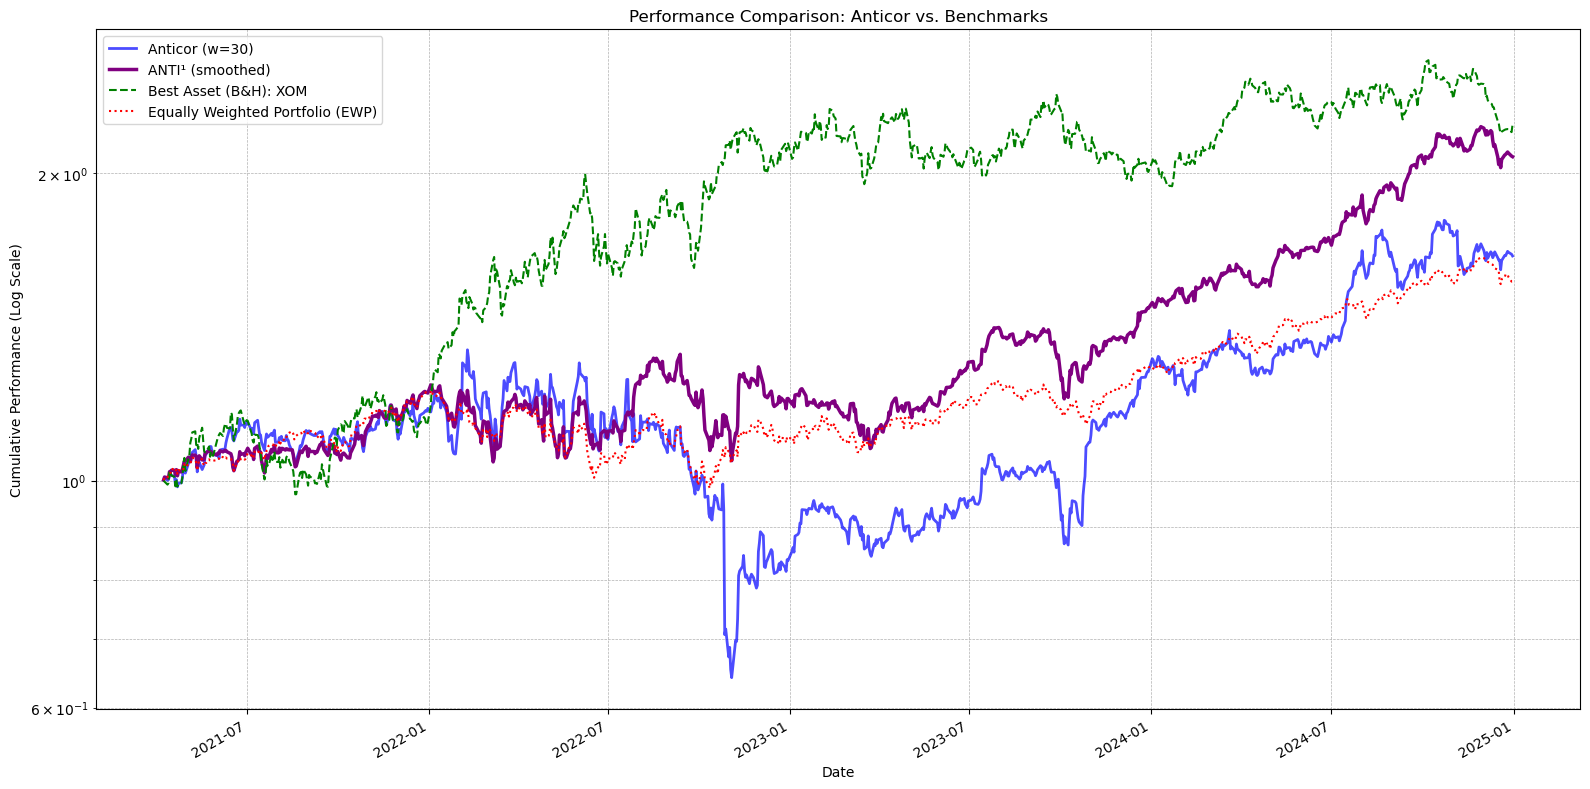

                  Cumulative Return  Annualized Return  Annualized Volatility  \
Anticor (w=30)             0.658532           0.145262               0.338883   
ANTI¹ (smoothed)           1.073932           0.215984               0.225018   
EWP                        0.565958           0.127762               0.145710   
Best Asset (XOM)           1.229450           0.240070               0.271777   

                  Sharpe Ratio  Max Drawdown  Calmar Ratio  
Anticor (w=30)        0.428648     -0.522017      0.278270  
ANTI¹ (smoothed)      0.959852     -0.212996      1.014029  
EWP                   0.876825     -0.197739      0.646118  
Best Asset (XOM)      0.883332     -0.205088      1.170570  


In [7]:

# =============================================================================
# STEP 7: VISUALIZATION AND KPIs (UPDATED)
# =============================================================================
print("\nStep 7: Generating chart and performance metrics...")
fig, ax = plt.subplots(figsize=(16, 8))

# 1. Anticor(w=30)
resultats_strategie['profit_cumule'].loc[start_date_strat:].plot(ax=ax, label='Anticor (w=30)', lw=2.0, color='blue', alpha=0.7)

# 2. ANTI¹ (smoothed)
resultats_anti1['profit_cumule'].plot(ax=ax, label='ANTI¹ (smoothed)', lw=2.5, color='purple')

# 3. Best Asset (B&H)
best_asset_perf.plot(ax=ax, label=f'Best Asset (B&H): {best_performing_ticker}', linestyle='--', color='green')

# 4. Equally Weighted Portfolio (EWP)
ewp_perf.plot(ax=ax, label='Equally Weighted Portfolio (EWP)', linestyle=':', color='red')

ax.set_title('Performance Comparison: Anticor vs. Benchmarks')
ax.set_ylabel('Cumulative Performance (Log Scale)')
ax.set_xlabel('Date')
ax.set_yscale('log')
ax.legend(loc='upper left')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# --- KPIs calculation and display ---
def calculate_performance_metrics(daily_returns_series, risk_free_rate=0.0):
    trading_days_per_year = 252
    cumulative_return = (1 + daily_returns_series).prod() - 1
    num_days = len(daily_returns_series)
    annualized_return = (1 + cumulative_return) ** (trading_days_per_year / num_days) - 1
    annualized_volatility = daily_returns_series.std() * np.sqrt(trading_days_per_year)
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility if annualized_volatility > 0 else 0

    cumulative_series = (1 + daily_returns_series).cumprod()
    peak = cumulative_series.expanding(min_periods=1).max()
    drawdown = (cumulative_series - peak) / peak
    max_drawdown = drawdown.min()
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown < 0 else 0

    return {
        "Cumulative Return": cumulative_return, "Annualized Return": annualized_return,
        "Annualized Volatility": annualized_volatility, "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown, "Calmar Ratio": calmar_ratio
    }

metrics = {}
metrics['Anticor (w=30)'] = calculate_performance_metrics(resultats_strategie['daily_profit'].loc[start_date_strat:])
metrics['ANTI¹ (smoothed)'] = calculate_performance_metrics(resultats_anti1['daily_profit'])
metrics['EWP'] = calculate_performance_metrics(ewp_daily_returns.loc[start_date_strat:])
metrics[f'Best Asset ({best_performing_ticker})'] = calculate_performance_metrics(best_asset_perf.pct_change().dropna())

results_table = pd.DataFrame(metrics).T
print(results_table)


In [8]:
import pandas as pd
import numpy as np

print("================ BEGINNING ANTI2 STRATEGY ================")


def run_anti2_strategy(price_relatives: pd.DataFrame, max_W: int, permno_to_ticker: dict):
    """
    Run the composite strategy ANTI² (BAH(ANTICOR(ANTICOR))).

    Optimizations:
    - Layer 1: call ANTICOR(w) with returns_only + common alignment (2*max_W).
    - Layer 2: reuse optimized ANTI¹ on the experts matrix.
    """
    print(f"Starting ANTI² backtest with W_max={max_W}...")

    # --- Layer 1: ANTICOR(w) on assets ---
    expert_daily_returns = {}
    start_idx = 2 * max_W

    print("  - Step 1/3: Computing Layer 1 experts (ANTICOR on assets)...")
    for w in range(2, max_W + 1):
        temp_results = run_anticor_strategy(
            price_relatives, w, permno_to_ticker,
            debug_days=0, returns_only=True, force_start_at_index=start_idx
        )
        expert_daily_returns[f"w_{w}"] = temp_results['daily_profit']
        if w % 5 == 0 or w == max_W:
            print(f"    -> Layer 1 expert (w={w}) computed.")

    # DataFrame of Layer 1 experts' returns (already aligned)
    anti1_returns_df = pd.DataFrame(expert_daily_returns)

    # --- Layer 2: Prepare relatives for ANTI¹ over experts ---
    print("\n  - Step 2/3: Preparing the relatives matrix for Layer 2...")
    anti1_relatives_matrix = 1 + anti1_returns_df.fillna(0.0)

    # Identity mapping for expert "tickers"
    w_to_ticker_map = {col: col for col in anti1_relatives_matrix.columns}

    # --- Layer 3: Run ANTI¹ over Layer 1 experts ---
    print("  - Step 3/3: Running Layer 2 (ANTI¹ over experts)...")
    resultats_anti2 = run_anti1_strategy(
        price_relatives=anti1_relatives_matrix,
        max_W=max_W,
        permno_to_ticker=w_to_ticker_map,
    )

    print("\nANTI² backtest completed!")
    return resultats_anti2


# --- Execution ---
# Ensure 'final_matrix_relatives' and 'permno_to_ticker' exist
resultats_anti2 = run_anti2_strategy(final_matrix_relatives, max_W=30, permno_to_ticker=permno_to_ticker)

================ BEGINNING ANTI2 STRATEGY ================
Starting ANTI² backtest with W_max=30...
  - Step 1/3: Computing Layer 1 experts (ANTICOR on assets)...
    -> Layer 1 expert (w=5) computed.
    -> Layer 1 expert (w=5) computed.
    -> Layer 1 expert (w=10) computed.
    -> Layer 1 expert (w=10) computed.
    -> Layer 1 expert (w=15) computed.
    -> Layer 1 expert (w=15) computed.
    -> Layer 1 expert (w=20) computed.
    -> Layer 1 expert (w=20) computed.
    -> Layer 1 expert (w=25) computed.
    -> Layer 1 expert (w=25) computed.
    -> Layer 1 expert (w=30) computed.

  - Step 2/3: Preparing the relatives matrix for Layer 2...
  - Step 3/3: Running Layer 2 (ANTI¹ over experts)...
Starting ANTI¹ backtest with W_max=30...
  - Computing expert ANTICOR(w=2)...
    -> Cumulative profit for w=2 (aligned): 2.1992
  - Computing expert ANTICOR(w=3)...
    -> Cumulative profit for w=3 (aligned): 2.7353
  - Computing expert ANTICOR(w=4)...
    -> Cumulative profit for w=4 (aligned


Step 8: Generating chart and performance metrics (with ANTI²)...


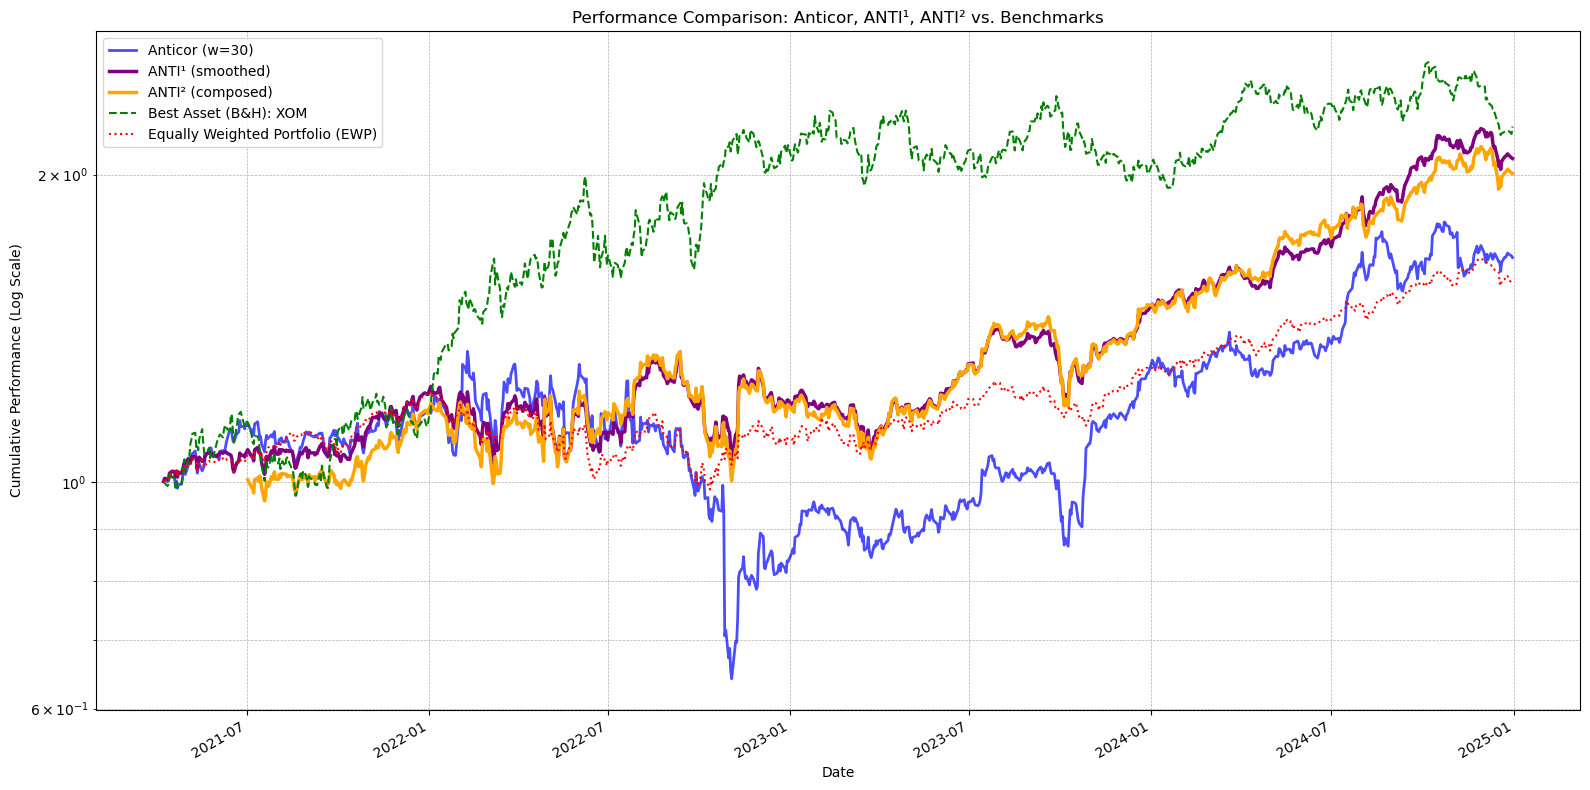

========================= Results Table ANTI² =========================

Chart generated and metrics calculated.
                  Cumulative Return  Annualized Return  Annualized Volatility  \
Anticor (w=30)             0.658532           0.145262               0.338883   
ANTI¹ (smoothed)           1.073932           0.215984               0.225018   
ANTI² (composed)           1.004572           0.220360               0.268406   
EWP                        0.565958           0.127762               0.145710   
Best Asset (XOM)           1.229450           0.240070               0.271777   

                  Sharpe Ratio  Max Drawdown  Calmar Ratio  
Anticor (w=30)        0.428648     -0.522017      0.278270  
ANTI¹ (smoothed)      0.959852     -0.212996      1.014029  
ANTI² (composed)      0.820995     -0.252781      0.871743  
EWP                   0.876825     -0.197739      0.646118  
Best Asset (XOM)      0.883332     -0.205088      1.170570  


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("\nStep 8: Generating chart and performance metrics (with ANTI²)...")

# --- Chart ---
fig, ax = plt.subplots(figsize=(16, 8))

# 1. Anticor(w=30)
# Align on the common start date
common_start_date = resultats_anti1.index[0]
anticor_w30_perf = (1 + resultats_strategie['daily_profit']).cumprod()
anticor_w30_perf.loc[common_start_date:].plot(ax=ax, label='Anticor (w=30)', lw=2.0, color='blue', alpha=0.7)

# 2. ANTI¹ (smoothed)
resultats_anti1['profit_cumule'].plot(ax=ax, label='ANTI¹ (smoothed)', lw=2.5, color='purple')

# 3. ANTI² (composed)
resultats_anti2['profit_cumule'].plot(ax=ax, label='ANTI² (composed)', lw=2.5, color='orange')

# 4. Best Asset (B&H)
best_asset_perf.plot(ax=ax, label=f'Best Asset (B&H): {best_performing_ticker}', linestyle='--', color='green')

# 5. Equally Weighted Portfolio (EWP)
ewp_perf.plot(ax=ax, label='Equally Weighted Portfolio (EWP)', linestyle=':', color='red')

ax.set_title('Performance Comparison: Anticor, ANTI¹, ANTI² vs. Benchmarks')
ax.set_ylabel('Cumulative Performance (Log Scale)')
ax.set_xlabel('Date')
ax.set_yscale('log')
ax.legend(loc='upper left')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# --- KPIs (updated) ---

# (Assumes calculate_performance_metrics is in memory)

metrics = {}
metrics['Anticor (w=30)'] = calculate_performance_metrics(resultats_strategie['daily_profit'].loc[common_start_date:])
metrics['ANTI¹ (smoothed)'] = calculate_performance_metrics(resultats_anti1['daily_profit'])
metrics['ANTI² (composed)'] = calculate_performance_metrics(resultats_anti2['daily_profit'])
metrics['EWP'] = calculate_performance_metrics(ewp_daily_returns.loc[common_start_date:])
metrics[f'Best Asset ({best_performing_ticker})'] = calculate_performance_metrics(best_asset_perf.pct_change().dropna())

results_table = pd.DataFrame(metrics).T

# Keep index names consistent with earlier output
aaa = f'Best Asset ({best_performing_ticker})'
results_table = results_table.rename(index={
    aaa: aaa
})

print("========================= Results Table ANTI² =========================")
print("\nChart generated and metrics calculated.")
print(results_table)


In [10]:
# Standardized persistence for multi-dataset comparison
import pandas as pd
from src.persist_backtest import save_backtest_results

# =====================================================================
# 1. Set the dataset identifier (CHANGE THIS EACH RUN)
# =====================================================================
dataset_id = "sp500_25diversified_jan2025"  # <-- Replace before running

# Safety check
if dataset_id == "CHANGE_ME_DATASET_NAME":
    raise ValueError("Please set a meaningful dataset_id before saving results.")

# =====================================================================
# 2. Build a unified equity curve DataFrame
# =====================================================================
# Each series represents cumulative performance (already in cumulative form)
# Convert to a DataFrame with aligned index

# Anticor base strategy cumulative
equity_anticor = (1 + resultats_strategie['daily_profit']).cumprod().rename("Anticor_w30")
# ANTI¹ cumulative already available
equity_anti1 = resultats_anti1['profit_cumule'].rename("ANTI1_smoothed")
# ANTI² cumulative already available
equity_anti2 = resultats_anti2['profit_cumule'].rename("ANTI2_composed")
# Benchmarks
bench_best_asset = best_asset_perf.rename("Best_Asset_BH")
bench_ewp = ewp_perf.rename("EWP")

# Align all on intersection of indices (inner join) to avoid mismatches
all_equity = [equity_anticor, equity_anti1, equity_anti2, bench_best_asset, bench_ewp]
common_index = all_equity[0].index
for s in all_equity[1:]:
    common_index = common_index.intersection(s.index)

# Reindex each to common_index
aligned_equity = [s.loc[common_index] for s in all_equity]
equity_df = pd.concat(aligned_equity, axis=1)

# =====================================================================
# 3. Prepare metrics object
# =====================================================================
# Use the printed table `results_table` (strategies + benchmarks) if available
# Fallback: compute minimal metrics if `results_table` is missing
if 'results_table' in globals():
    # DataFrame -> dict-of-dicts
    metrics_obj = results_table.to_dict(orient='index')
else:
    metrics_obj = {}
    # Minimal placeholder metrics
    for col in equity_df.columns:
        series = equity_df[col]
        daily_ret = series.pct_change().dropna()
        if len(daily_ret) > 0:
            cum_ret = series.iloc[-1] / series.iloc[0] - 1
            metrics_obj[col] = {"Cumulative Return": float(cum_ret)}

# =====================================================================
# 4. Persist results
# =====================================================================
summary = save_backtest_results(
    equity_df=equity_df,
    trades_df=None,            # No explicit trades DataFrame in current workflow
    metrics_obj=metrics_obj,   # Structured metrics
    dataset_id=dataset_id,
    extra_namespace=globals(), # Allows automatic pickup of loose metric vars
)

print(f"Results saved for dataset_id='{dataset_id}'.")
print("Summary keys:", list(summary.keys()))
print(summary)

# Quick reminder for next runs:
# - Change dataset_id at top
# - Run entire notebook
# - Execute this cell last to append to master JSONL


Results saved for dataset_id='sp500_25diversified_jan2025'.
Summary keys: ['dataset_id', 'equity_curve_file', 'Anticor (w=30)', 'ANTI¹ (smoothed)', 'ANTI² (composed)', 'EWP', 'Best Asset (XOM)', 'summary_file']
{'dataset_id': 'sp500_25diversified_jan2025', 'equity_curve_file': 'results/backtests/sp500_25diversified_jan2025_equity.csv', 'Anticor (w=30)': {'Cumulative Return': 0.6585320234298706, 'Annualized Return': 0.14526158802755318, 'Annualized Volatility': 0.33888304386573, 'Sharpe Ratio': 0.4286481447124506, 'Max Drawdown': -0.5220168084089458, 'Calmar Ratio': 0.2782699439703785}, 'ANTI¹ (smoothed)': {'Cumulative Return': 1.0739316347250707, 'Annualized Return': 0.21598402694317342, 'Annualized Volatility': 0.22501806793608822, 'Sharpe Ratio': 0.9598519306659378, 'Max Drawdown': -0.2129958965067444, 'Calmar Ratio': 1.0140290516645443}, 'ANTI² (composed)': {'Cumulative Return': 1.0045723915100098, 'Annualized Return': 0.2203602270815166, 'Annualized Volatility': 0.26840613819740844